In [1]:
import json
from pathlib import Path
import sys

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

sys.path.append("../")

# Import custom modules
from src.analytics.static_analysis import (
    get_cluster_colors,
    get_cluster_markers,
    get_marker_size_corrections,
)
from src.exporters.cluster_exporter import (
    export_gauge_mapping_csv,
)
from src.plots.cluster_plots import (
    plot_hybrid_spatial_clusters,
)
from src.plots.maps import russia_plots
from src.readers.geom_reader import load_geodata
from src.utils.logger import setup_logger

plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

log = setup_logger("chapter_one", log_file="../logs/chapter_one.log")


In [2]:
# Load watershed geometries and gauge locations
ws, gauges = load_geodata(folder_depth="../")
basemap_data = gpd.read_file("../data/geometry/basemap_2023.gpkg")
common_index = gauges.index.to_list()

print(f"Loaded {len(gauges)} gauges and {len(ws)} watersheds")


Loaded 996 gauges and 996 watersheds


In [3]:
geo_scaled = pd.read_csv(
    "../res/chapter_one/tables/geo_scaled_features.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)
q_df_clust = pd.read_csv(
    "../res/chapter_one/tables/hydro_scaled_features.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)
hydro_clustered = gpd.read_file(
    "../res/chapter_one/tables/hydro_clustered_gauges.geojson"
)
hydro_labels = hydro_clustered["Cluster_Name"].values
geo_labels = [f"Ф{cl}" for cl in geo_scaled["cluster_geo"].values]


Raw hybrid combinations: 64
Combination counts:
hybrid_combo
Ф4-Г8     79
Ф1-Г5     65
Ф9-Г7     60
Ф10-Г3    58
Ф5-Г2     53
          ..
Ф2-Г2      2
Ф1-Г7      1
Ф3-Г10     1
Ф7-Г7      1
Ф6-Г3      1
Name: count, Length: 64, dtype: int64

Significant combinations (≥5 gauges): 15

Consolidated to 16 hybrid classes

Hybrid Class Summary:
              n_gauges geo_clusters                   hydro_clusters
hybrid_class                                                        
Ф4-Г8              157           Ф4      Г1, Г10, Г3, Г6, Г7, Г8, Г9
Ф10-Г3             119          Ф10           Г2, Г3, Г5, Г6, Г7, Г9
Ф9-Г7              110           Ф9              Г1, Г10, Г4, Г7, Г8
Ф1-Г5               81           Ф1          Г10, Г2, Г4, Г5, Г7, Г9
Ф8-Г2               74           Ф8  Г1, Г10, Г2, Г4, Г5, Г7, Г8, Г9
Ф7-Г1               71           Ф7      Г1, Г10, Г3, Г6, Г7, Г8, Г9
Ф5-Г2               63           Ф5              Г1, Г10, Г2, Г3, Г9
Ф2-Mixed            54           Ф2 

2025-12-29 16:42:43 | INFO     | PhDLogger | src.plots.cluster_plots | ℹ️  Saved hybrid spatial cluster map to ../res/chapter_one/map_hybrid_classes_watersheds.png


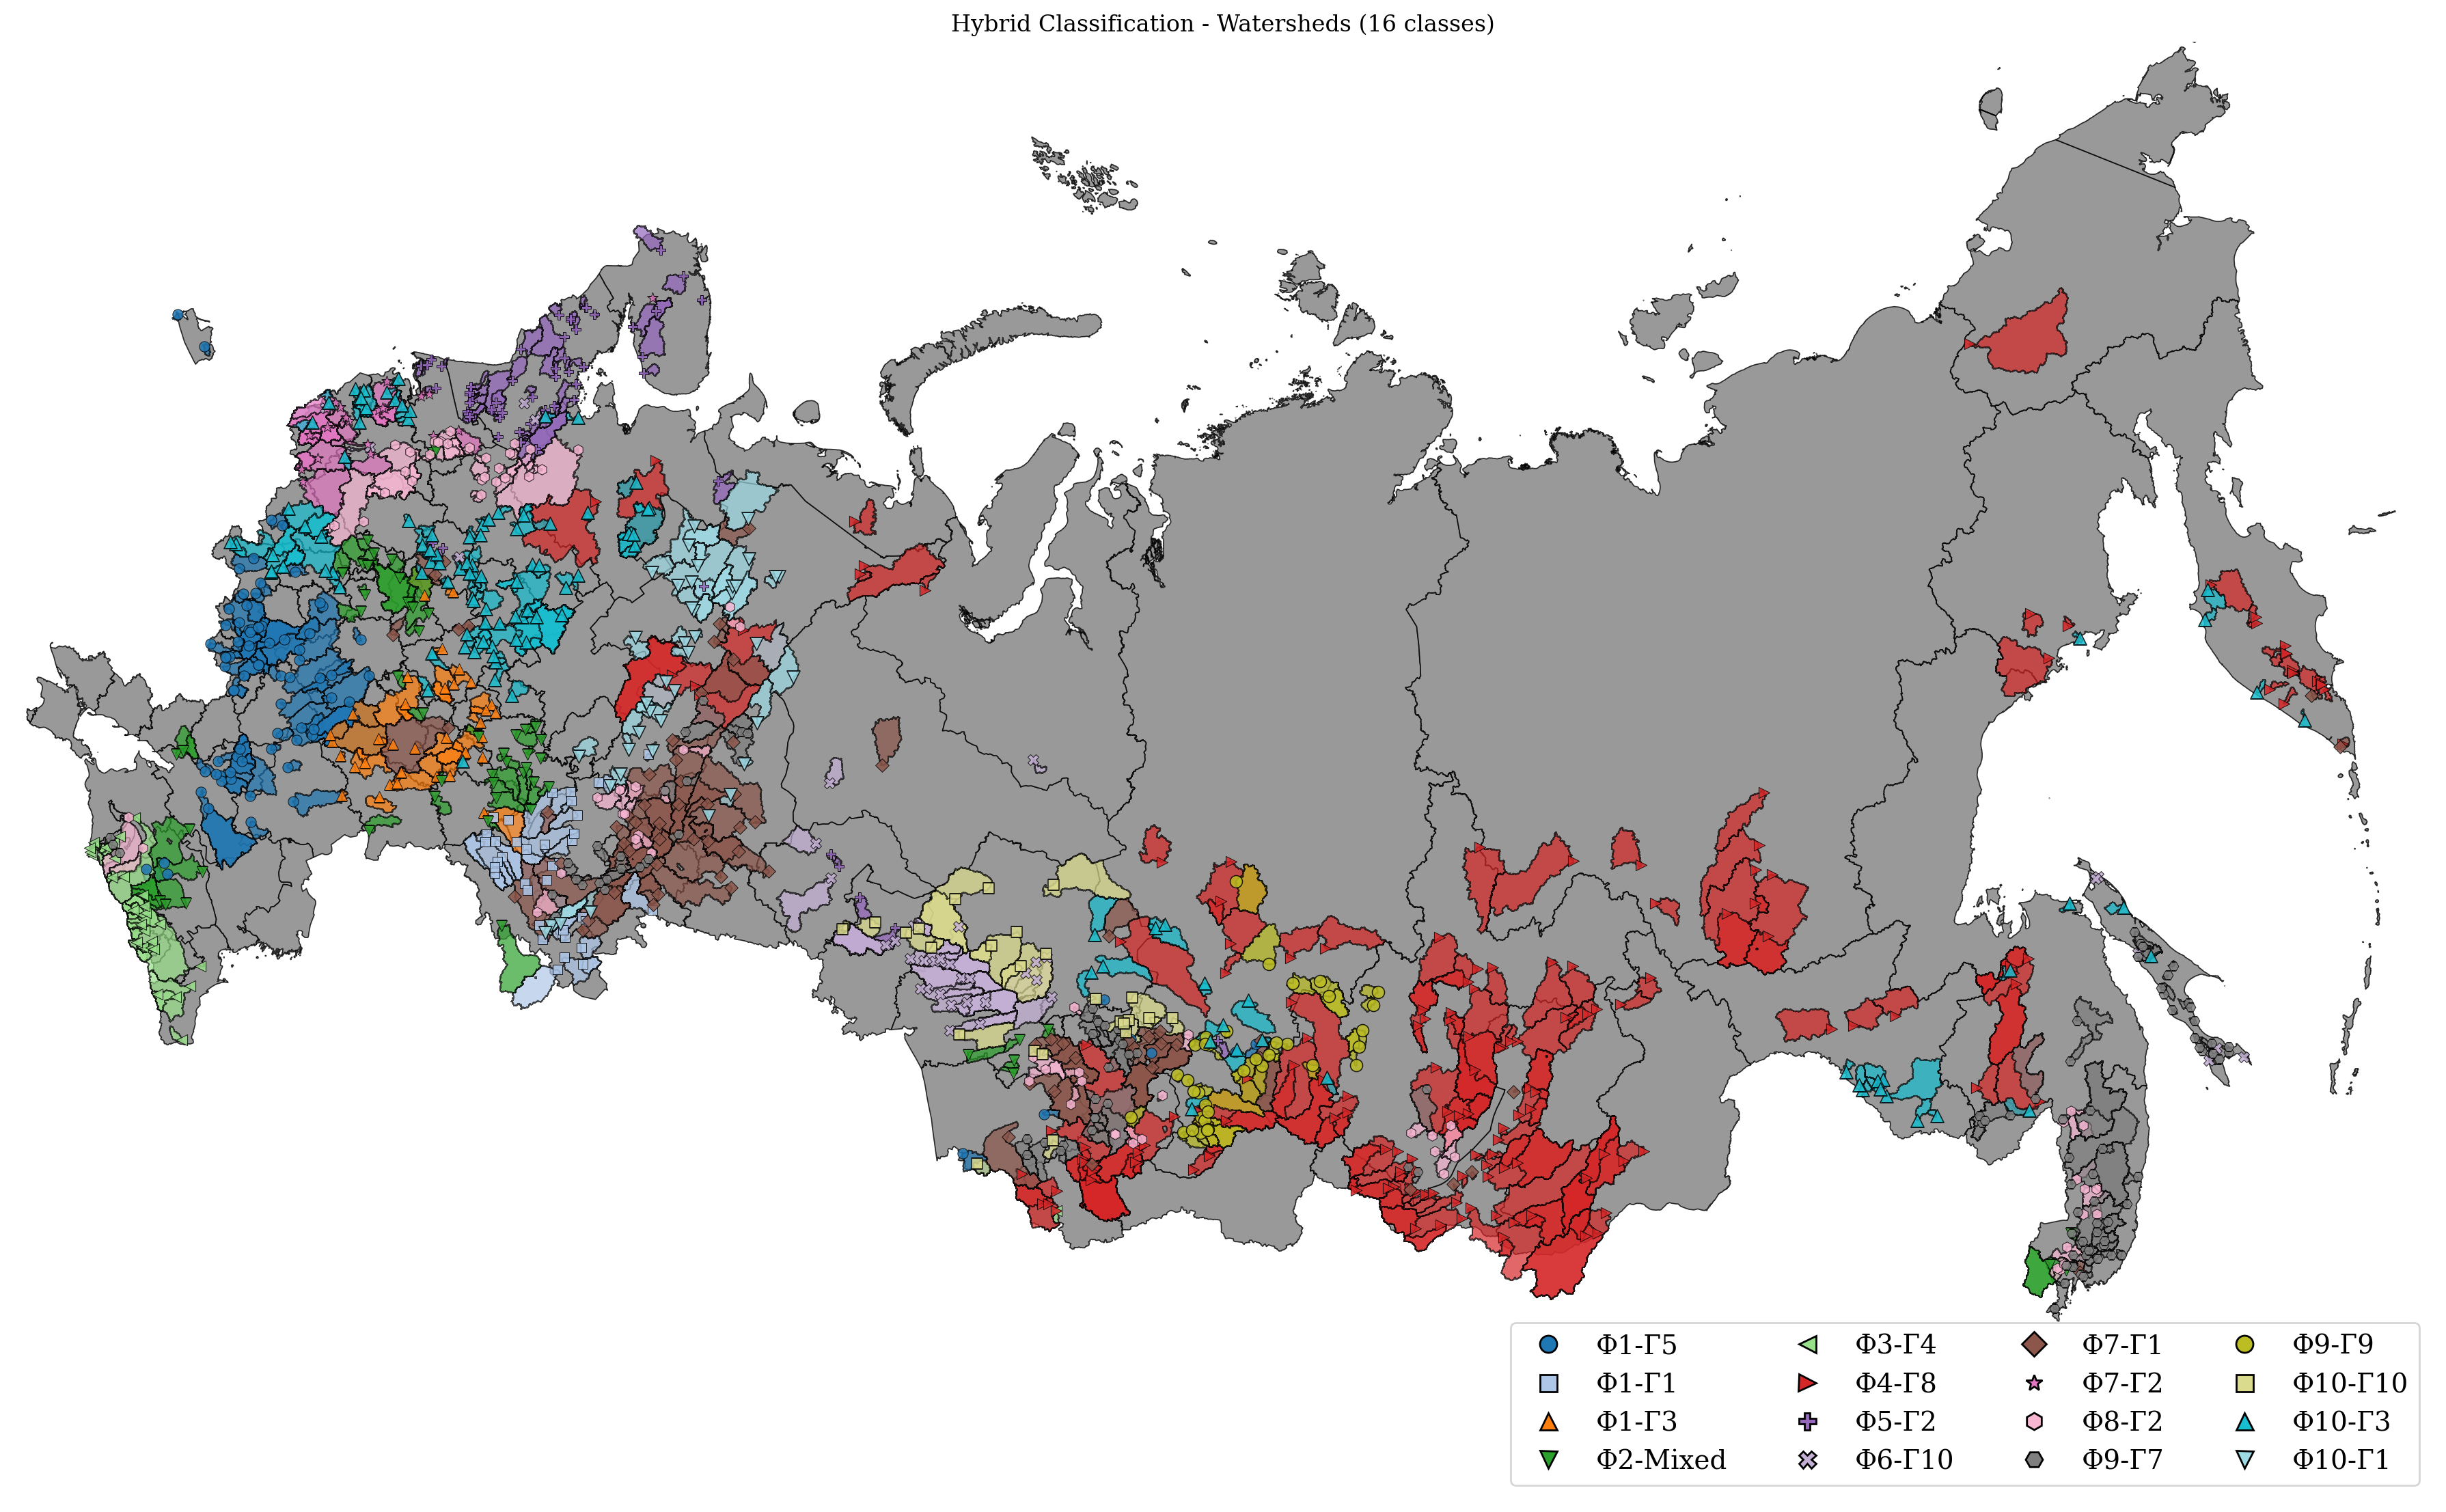

In [4]:
# Create mapping for common gauges
common_gauges = q_df_clust.index.to_list()
geo_mapping = pd.Series(geo_labels, index=geo_scaled.index)
hydro_mapping = pd.Series(hydro_labels, index=q_df_clust.index)

# Build gauge mapping with hybrid labels
gauge_mapping = pd.DataFrame(
    {
        "gauge_id": common_gauges,
        "geo_cluster": geo_mapping.loc[common_gauges].values,
        "hydro_cluster": hydro_mapping.loc[common_gauges].values,
    }
)

# Create hybrid labels
gauge_mapping["hybrid_combo"] = gauge_mapping.apply(
    lambda row: f"{row['geo_cluster']}-{row['hydro_cluster']}", axis=1
)
print(f"\nRaw hybrid combinations: {gauge_mapping['hybrid_combo'].nunique()}")

# Consolidate hybrid combinations using proper strategy
# Strategy: Keep top combinations, merge rare ones by geo cluster
combo_counts = gauge_mapping["hybrid_combo"].value_counts()
target_n_classes = 15
min_gauges = 5


print(f"Combination counts:\n{combo_counts}\n")

# Keep significant combinations
significant_combos = combo_counts[combo_counts >= min_gauges].head(target_n_classes)
print(f"Significant combinations (≥{min_gauges} gauges): {len(significant_combos)}")

# Create mapping
combo_mapping = {}

# Assign significant combos directly
for combo in significant_combos.index:
    combo_mapping[combo] = combo

# For rare combinations, merge by geo cluster
rare_combos = combo_counts[~combo_counts.index.isin(significant_combos.index)]

for combo in rare_combos.index:
    geo_cluster = combo.split("-")[0]  # Extract Ф1, Ф2, etc.

    # Find significant combos with same geo cluster
    geo_matches = [c for c in significant_combos.index if c.startswith(geo_cluster + "-")]

    if geo_matches:
        # Assign to most common geo-matched combo
        combo_mapping[combo] = geo_matches[0]
    else:
        # Group as "Ф#-Mixed"
        combo_mapping[combo] = f"{geo_cluster}-Mixed"

# Apply mapping
gauge_mapping["hybrid_class"] = gauge_mapping["hybrid_combo"].map(combo_mapping)

print(f"\nConsolidated to {gauge_mapping['hybrid_class'].nunique()} hybrid classes")
# Summary table of hybrid classes
class_summary = (
    gauge_mapping.groupby("hybrid_class")
    .agg(
        {
            "gauge_id": "count",
            "geo_cluster": lambda x: sorted(set(x)),
            "hydro_cluster": lambda x: sorted(set(x)),
        }
    )
    .rename(columns={"gauge_id": "n_gauges"})
)

class_summary = class_summary.sort_values("n_gauges", ascending=False)
class_summary["geo_clusters"] = class_summary["geo_cluster"].apply(
    lambda x: ", ".join([f"{i}" for i in x])
)
class_summary["hydro_clusters"] = class_summary["hydro_cluster"].apply(
    lambda x: ", ".join([f"{i}" for i in x])
)

print("\nHybrid Class Summary:")
print("=" * 80)
print(class_summary[["n_gauges", "geo_clusters", "hydro_clusters"]].to_string())
print("=" * 80)
print(f"\nTotal classes: {len(class_summary)}")
print(f"Total gauges: {class_summary['n_gauges'].sum()}")
print(f"Mean gauges per class: {class_summary['n_gauges'].mean():.1f}")
print(f"Median gauges per class: {class_summary['n_gauges'].median():.1f}")

# Plot hybrid spatial distribution with watersheds
fig_hybrid_ws = plot_hybrid_spatial_clusters(
    watersheds=ws,
    gauges=gauges,
    gauge_mapping=gauge_mapping,
    hybrid_col="hybrid_class",
    basemap=basemap_data,
    output_path="../res/chapter_one/map_hybrid_classes_watersheds.png",
    title=f"Hybrid Classification - Watersheds ({len(class_summary)} classes)",
    show_watersheds=True,
    show_gauges=True,
)
plt.show()


In [5]:
# Export gauge mapping
gauge_mapping_export = gauge_mapping.copy()
# geo_cluster and hydro_cluster already have Ф and Г prefixes, so just copy them
gauge_mapping_export["geo_cluster_ru"] = gauge_mapping_export["geo_cluster"]
gauge_mapping_export["hydro_cluster_ru"] = gauge_mapping_export["hydro_cluster"]

export_gauge_mapping_csv(
    gauge_mapping_export,
    output_path="../res/chapter_one/gauge_hybrid_mapping.csv",
    columns=[
        "gauge_id",
        "geo_cluster_ru",
        "hydro_cluster_ru",
        "hybrid_combo",
        "hybrid_class",
    ],
)

print("✓ Exported gauge mapping to CSV")


✓ Exported gauge mapping to CSV


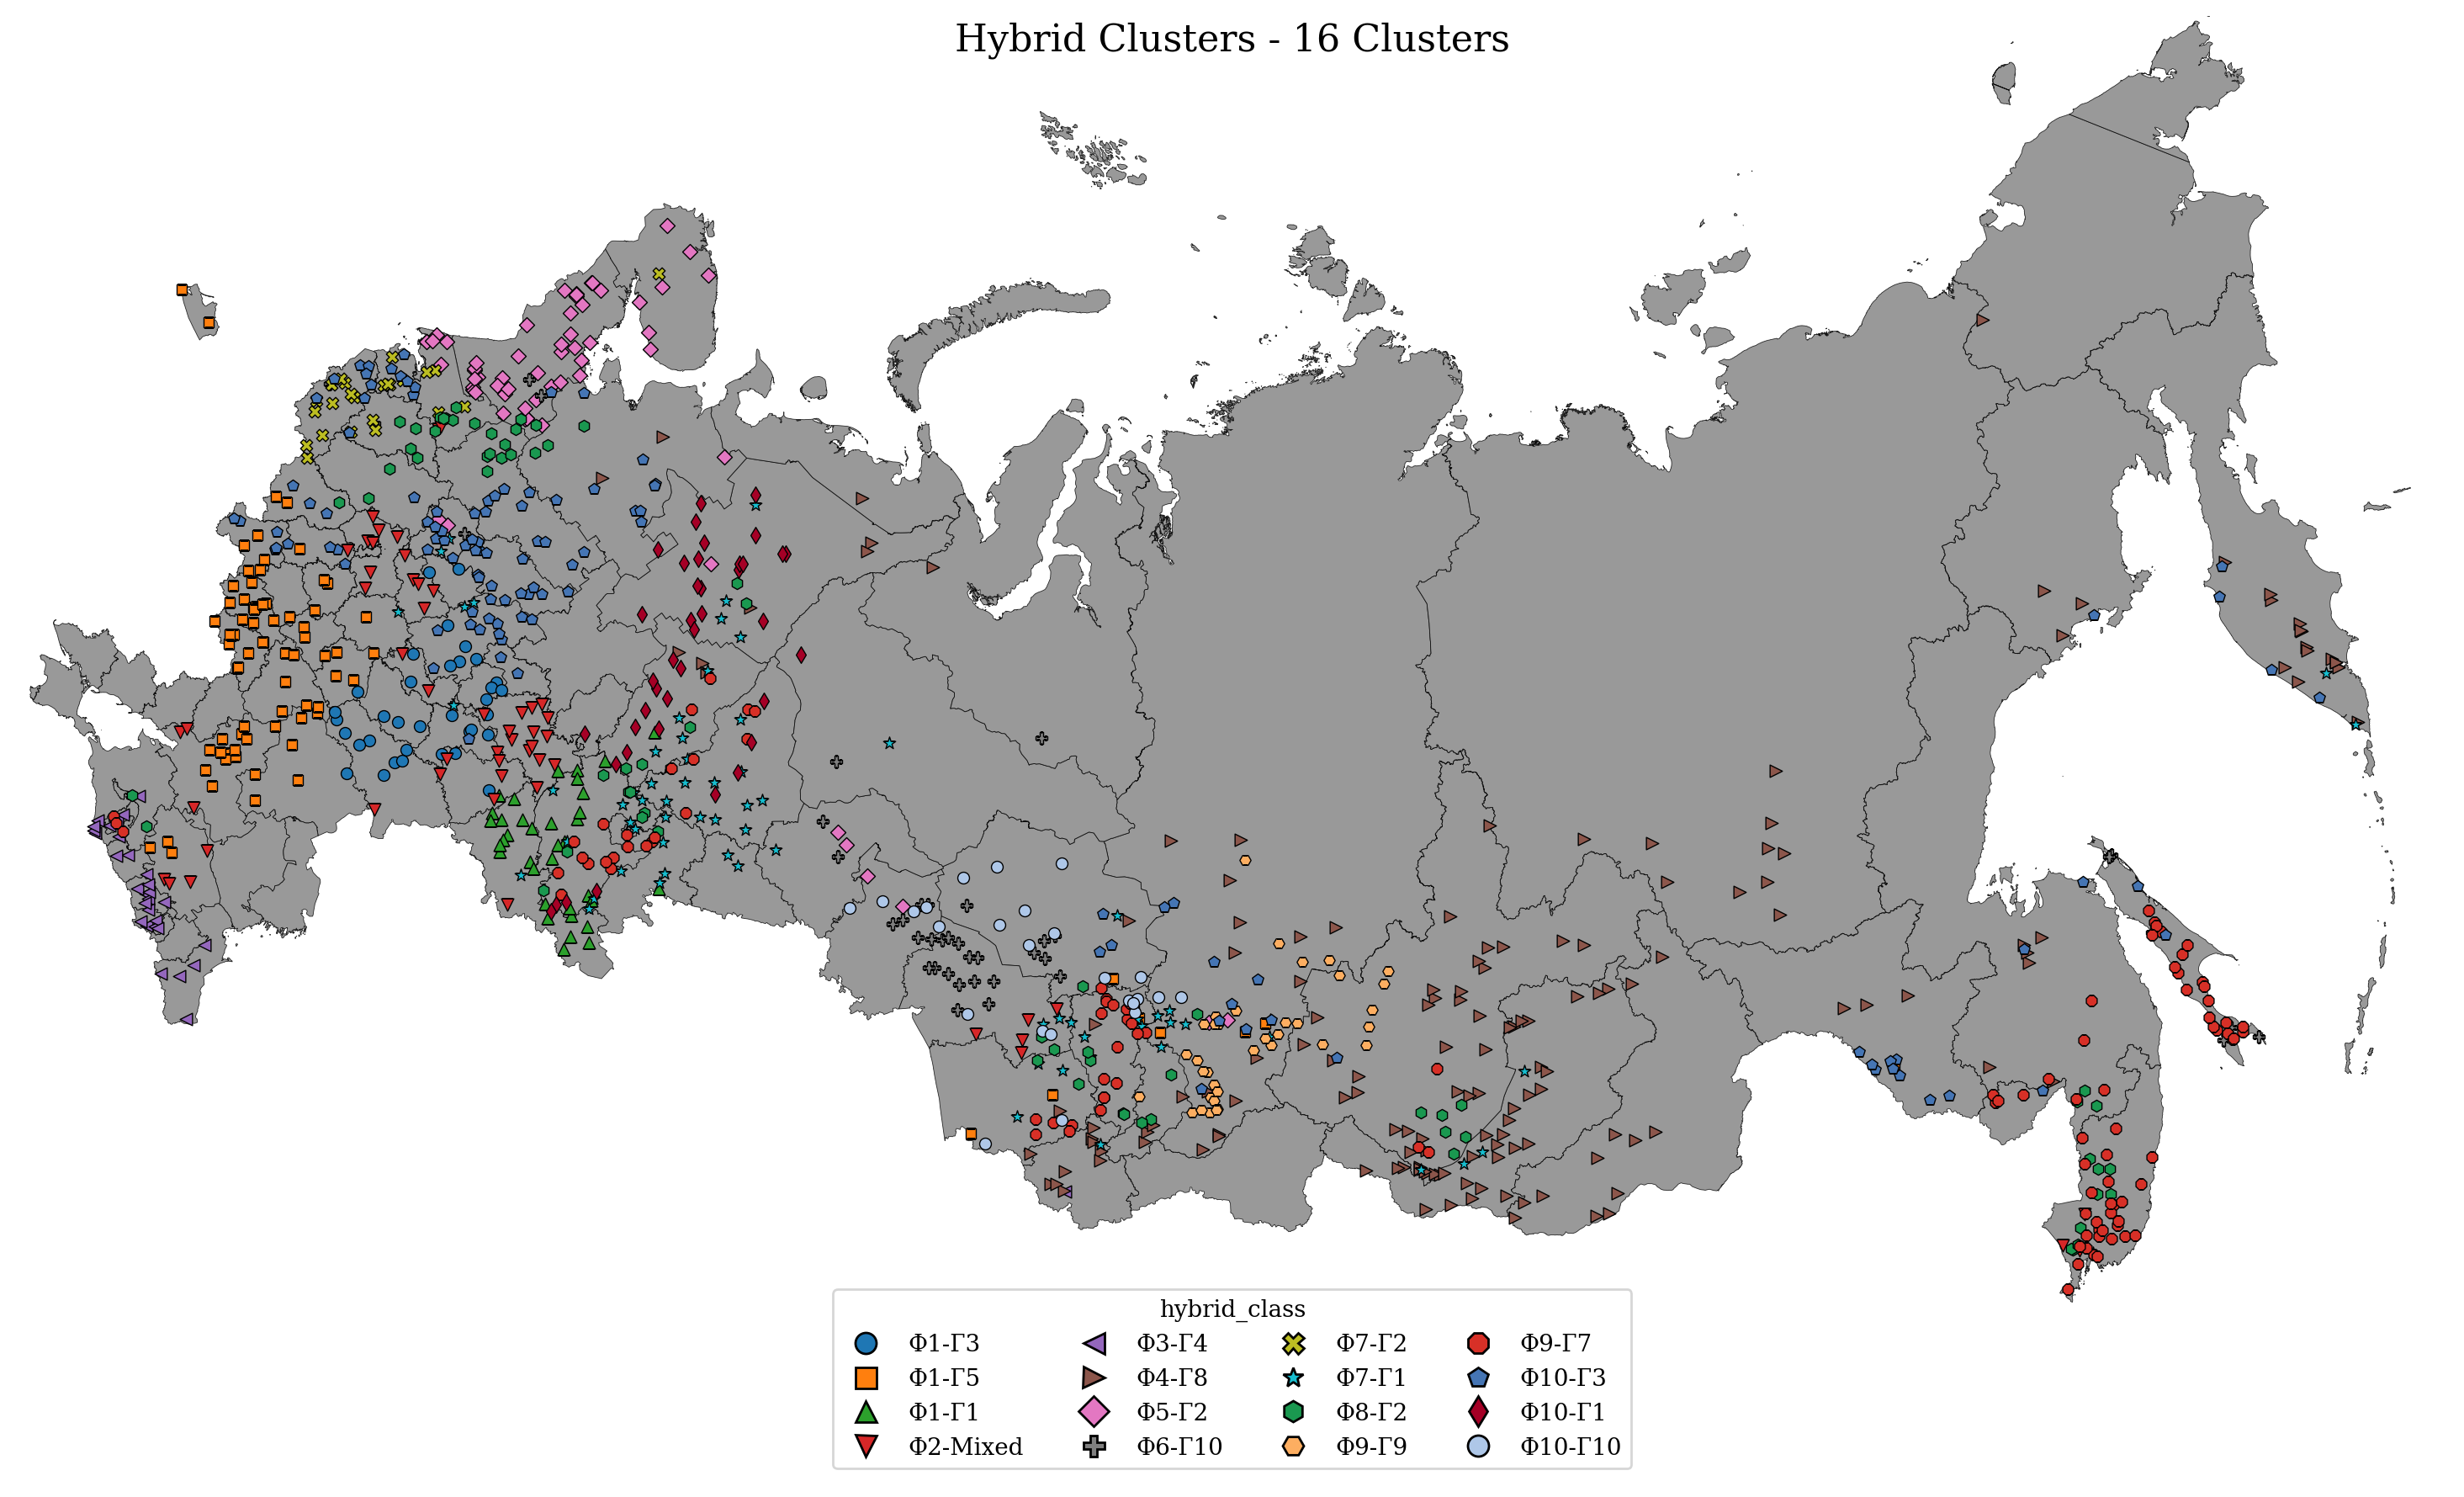

In [6]:
n_hybrid_classes = gauge_mapping_export["hybrid_class"].nunique()
# Get markers and colors for clusters
markers_hc = get_cluster_markers(n_hybrid_classes)
colors_hc = get_cluster_colors(n_hybrid_classes)
marker_corrections = get_marker_size_corrections()
# Prepare cluster names for geographic visualization
gauge_clustered = gauges.copy()
# Map hybrid_class from gauge_mapping_export to gauge_clustered using the index
gauge_clustered["hybrid_class"] = gauge_clustered.index.map(
    gauge_mapping_export.set_index("gauge_id")["hybrid_class"]
)

# Plot map with proper cluster names
fig_clusters_map = russia_plots(
    gdf_to_plot=gauge_clustered,
    basemap_data=basemap_data,
    distinction_col="hybrid_class",
    markers_list=markers_hc,
    color_list=colors_hc,
    marker_size_corrections=marker_corrections,
    figsize=(16, 9),
    just_points=True,
    legend_cols=4,
    base_marker_size=25,
    base_linewidth=0.5,
)

fig_clusters_map.suptitle(
    f"Hybrid Clusters - {n_hybrid_classes} Clusters",
    fontsize=16,
    y=0.98,
)
fig_clusters_map.savefig(
    "../res/chapter_one/hybrid_clusters_map.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


In [7]:
def load_cluster_descriptions_from_json(filepath: Path) -> dict:
    """Load cluster descriptions from JSON file.

    Args:
        filepath: Path to JSON description file

    Returns:
        Dictionary mapping cluster IDs (as strings) to their name and interpretation
    """
    descriptions = {}

    with open(filepath, encoding="utf-8") as f:
        data = json.load(f)

    for cluster in data:
        # Convert cluster_id to string for consistent key lookup
        cluster_id = str(cluster["cluster_id"]).replace("Г", "")  # Remove Г if present

        descriptions[cluster_id] = {
            "name": cluster["cluster_name"],
            "interpretation": cluster["interpretation"],
        }

    return descriptions


def generate_hybrid_descriptions(
    class_summary: pd.DataFrame, geo_descs: dict, hydro_descs: dict
) -> dict:
    """Generate hybrid cluster descriptions by combining geo and hydro narratives.

    Args:
        class_summary: DataFrame with hybrid class information
        geo_descs: Geographical cluster descriptions
        hydro_descs: Hydrological cluster descriptions

    Returns:
        Dictionary mapping hybrid class IDs to their descriptions
    """
    hybrid_descriptions = {}

    for hybrid_id, row in class_summary.iterrows():
        # Parse hybrid ID (e.g., "Ф4-Г8" or "Ф2-Mixed")
        parts = hybrid_id.split("-")
        geo_id = parts[0].replace("Ф", "")  # Remove Ф prefix to get number
        hydro_part = parts[1]

        # Get geo description
        geo_info = geo_descs.get(geo_id, {})
        geo_name = geo_info.get("name", f"Cluster {geo_id}")
        geo_interp = geo_info.get("interpretation", "No description available.")

        # Handle Mixed vs Standard hybrid classes
        if hydro_part == "Mixed":
            # Mixed class: emphasize geo characteristics with diverse hydrology
            description = (
                f"**{hybrid_id}**: This hybrid class is defined by {geo_name.lower()} "
                f"landscape characteristics. {geo_interp} "
                f"This landscape supports a diverse range of hydrological regimes with "
                f"no single dominant pattern, reflecting heterogeneous climate forcing, "
                f"varied watershed properties, or complex anthropogenic influences."
            )
        else:
            # Standard class: combine geo and hydro
            hydro_id = hydro_part.replace("Г", "")  # Remove Г prefix
            hydro_info = hydro_descs.get(hydro_id, {})
            hydro_name = hydro_info.get("name", f"Cluster {hydro_id}")
            hydro_interp = hydro_info.get("interpretation", "No description available.")

            description = (
                f"**{hybrid_id}**: This hybrid class combines {geo_name.lower()} "
                f"landscape characteristics with {hydro_name.lower()} hydrological patterns. "
                f"Geographically, {geo_interp} "
                f"Hydrologically, {hydro_interp} "
                f"The convergence of these geographical and hydrological traits creates "
                f"a distinct hydroecological regime with {row['n_gauges']} representative catchments."
            )

        hybrid_descriptions[hybrid_id] = description

    return hybrid_descriptions


def save_hybrid_descriptions(
    descriptions: dict, output_path: Path, class_summary: pd.DataFrame
):
    """Save hybrid descriptions to JSON file.

    Args:
        descriptions: Dictionary of hybrid descriptions
        output_path: Path to output file (will save as .json)
        class_summary: DataFrame with class statistics for summary table
    """
    # Sort by number of gauges (descending)
    sorted_ids = class_summary.sort_values("n_gauges", ascending=False).index

    # Build JSON structure
    output_data = []

    for hybrid_id in sorted_ids:
        row = class_summary.loc[hybrid_id]
        description = descriptions[hybrid_id]

        # Parse hybrid ID to get components
        parts = hybrid_id.split("-")
        geo_id = parts[0].replace("Ф", "")
        hydro_part = parts[1]

        output_data.append(
            {
                "hybrid_id": hybrid_id,
                "geo_cluster_id": geo_id,
                "hydro_cluster_id": hydro_part,
                "n_catchments": int(row["n_gauges"]),
                "geo_clusters": row["geo_clusters"],
                "hydro_clusters": row["hydro_clusters"],
                "description": description,
            }
        )

    # Save as JSON
    json_path = output_path.with_suffix(".json")
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(output_data, f, indent=2, ensure_ascii=False)

    log.info(f"✓ Saved hybrid descriptions to {json_path}")


# Step 1: Load description files from JSON
log.info("Loading geographical cluster descriptions from JSON...")
geo_descs = load_cluster_descriptions_from_json(
    Path("../res/chapter_one/geo_cluster_descriptions.json")
)

log.info("Loading hydrological cluster descriptions from JSON...")
hydro_descs = load_cluster_descriptions_from_json(
    Path("../res/chapter_one/hydro_cluster_descriptions.json")
)

log.info(
    f"✓ Loaded {len(geo_descs)} geo descriptions and {len(hydro_descs)} hydro descriptions"
)

# Step 2: Generate hybrid narratives
log.info("Generating hybrid cluster descriptions...")
hybrid_descriptions = generate_hybrid_descriptions(
    class_summary=class_summary, geo_descs=geo_descs, hydro_descs=hydro_descs
)

log.info(f"✓ Generated {len(hybrid_descriptions)} hybrid descriptions")

# Step 3: Save and display
output_path = Path("../res/chapter_one/hybrid_cluster_descriptions.json")
save_hybrid_descriptions(
    descriptions=hybrid_descriptions, output_path=output_path, class_summary=class_summary
)

# Display in Markdown format
print("\n" + "=" * 100)
print("HYBRID CLUSTER DESCRIPTIONS")
print("=" * 100 + "\n")

# Sort by number of gauges for display
sorted_ids = class_summary.sort_values("n_gauges", ascending=False).index

for hybrid_id in sorted_ids:
    row = class_summary.loc[hybrid_id]
    description = hybrid_descriptions[hybrid_id]

    print(f"\n### {hybrid_id} ({row['n_gauges']} catchments)")
    print(f"**Geo Clusters:** {row['geo_clusters']}")
    print(f"**Hydro Clusters:** {row['hydro_clusters']}")
    print()
    print(description.replace(f"**{hybrid_id}**: ", ""))
    print("\n" + "-" * 100)

print(f"\n✓ All descriptions saved to: {output_path}")


2025-12-29 16:42:45 | INFO     | PhDLogger | chapter_one | ℹ️  Loading geographical cluster descriptions from JSON...
2025-12-29 16:42:45 | INFO     | PhDLogger | chapter_one | ℹ️  Loading hydrological cluster descriptions from JSON...
2025-12-29 16:42:45 | INFO     | PhDLogger | chapter_one | ℹ️  ✓ Loaded 10 geo descriptions and 10 hydro descriptions
2025-12-29 16:42:45 | INFO     | PhDLogger | chapter_one | ℹ️  Generating hybrid cluster descriptions...
2025-12-29 16:42:45 | INFO     | PhDLogger | chapter_one | ℹ️  ✓ Generated 16 hybrid descriptions
2025-12-29 16:42:45 | INFO     | PhDLogger | chapter_one | ℹ️  ✓ Saved hybrid descriptions to ../res/chapter_one/hybrid_cluster_descriptions.json



HYBRID CLUSTER DESCRIPTIONS


### Ф4-Г8 (157 catchments)
**Geo Clusters:** Ф4
**Hydro Clusters:** Г1, Г10, Г3, Г6, Г7, Г8, Г9

This hybrid class combines karst (17.0) / semi-arid (0mm/yr) landscape characteristics with cluster 8 hydrological patterns. Geographically, Cluster 4 encompasses 157 catchments characterized by high-elevation (1033 m) mountainous terrain with steep slopes (10.2°). Dense forest cover (67%) dominates the landscape, with minimal agricultural development (1% cropland). Mixed soil texture (clay: 10%, silt: 41%, sand: 48%) provides intermediate infiltration characteristics. Inundation-prone areas (2.0%) offer flood storage capacity and wetland ecosystems. Deep groundwater tables (2.6 m) limit groundwater-surface water exchange. Karst features (17%) create subsurface flow pathways. Extensive permafrost (53%) severely restricts infiltration and creates extreme seasonal flow patterns. Permafrost dominance creates highly seasonal discharge with minimal winter baseflow.